In [1]:
%pip install optproblems
%pip install numpy
%pip install matplotlib

import copy
import numpy as np
import random
import optproblems.cec2005 as test_funcs
from optproblems import *
import matplotlib.pyplot as plt

random.seed(100)
np.random.seed(100)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
def Shifted_Rastrigin(input):
    func = test_funcs.F9(len(input))
    sol = Individual(input)
    func.evaluate(sol)
    return sol.objective_values

In [3]:
def Sphere(input):
    func = test_funcs.F1(len(input))
    sol = Individual(input)
    func.evaluate(sol)
    return sol.objective_values

In [4]:
# Expanded extended Griewank’s plus Rosenbrock’s function (F8F2)

def shifted_f13(input):
    func = test_funcs.F13(len(input))
    sol = Individual(input)
    func.evaluate(sol)
    return sol.objective_values

In [5]:
def make_line_graph(value_list, line_label, xlimits, ylimits):
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.xlabel("Iteration")
    plt.ylabel("Fitness")
    ax.plot(value_list, label= line_label, color = 'blue')
    plt.legend(loc='best')
    plt.xlim(xlimits)
    plt.ylim(ylimits)
    plt.show(block=True)

In [6]:
class PSO():
    
    def __init__(self, swarm_size, particle_dimensions, \
                 w_init,w_final, c1, c2, c3, e):
        self.w_init = w_init
        self.w_final = w_final
        self.c1 = c1
        self.c2 = c2
        self.c3 = c3
        self.e = e
        self.swarm_size = swarm_size
        self.dimensions = particle_dimensions  # INT
        self.swarm = []
        self.best_fitness_list = []
        self.global_best_particle = None
        
    def generate_random_population(self, min_value, max_value):
        
        for i in range(self.swarm_size):
            pos = np.random.uniform(min_value,max_value,self.dimensions)
            vel = np.zeros(self.dimensions)
             
            fitness = self.calculate_fitness(pos)
            self.swarm.append(Particle (pos, vel, fitness))
            
            if self.global_best_particle is None:
                self.global_best_particle = copy.copy(self.swarm[-1])
            else:
                if self.global_best_particle.fitness > self.swarm[-1].fitness:
                    self.global_best_particle = copy.copy(self.swarm[-1])
    
    
    def run(self, benchmark, iterations, min_value, max_value, num_informants):
        self.benchmark_func = benchmark
        self.iterations = iterations
    
        self.generate_random_population(min_value, max_value)
        self.add_informants_to_particles(num_informants)
        
        for i in range(iterations):
            
            self.best_fitness_list.append(self.global_best_particle.fitness)
            if i % 100 == 0:
                print ("Iteration {} | Best Fitness | {}".format\
                       (i, self.global_best_particle.fitness))
                
            # Shuffling to give all particles equal chances to move first
            random.shuffle(self.swarm) 
           
            for particle in self.swarm:
                
                # Implementing linear decreasing inertia weight 
                w = (self.w_init - self.w_final)*((iterations - i)/iterations)\
                    + self.w_final
                
                particle.update_velocity(self.global_best_particle,\
                                        w, self.c1, self.c2, self.c3)
                
                # Clipping Velocity to stop particles to wander
                particle.velocity = np.clip(particle.velocity, -0.2*\
                        abs(max_value - min_value), 0.2*abs(max_value - min_value))

                particle.update_position(min_value, max_value, self.e) 
                particle.fitness = self.calculate_fitness(particle.position)
                particle.check_best_point()
                if particle.fitness < self.global_best_particle.best_fitness:
                    self.global_best_particle = copy.copy(particle)
        print ("Final Best Fitness | {}".format(self.global_best_particle.fitness))
        self.best_fitness_list.append(self.global_best_particle.fitness)
        return self.best_fitness_list
    
    
    def calculate_fitness(self, position):
        return self.benchmark_func(position)
    
    
    def add_informants_to_particles(self, num_informants):
        temp_swarm = self.swarm.copy()
        for particle in self.swarm:
            temp_swarm.pop(0)
            particle.add_informants(random.choices(temp_swarm, k=num_informants))
            temp_swarm.append(particle)
    
    
    def update_particle_fitness(self, particle, new_values):
        particle.check_best_point()

In [7]:
class Particle():
    
    def __init__(self, position, velocity, fitness):
        self.position = position
        self.best_position = position
        self.velocity = velocity
        self.fitness = fitness
        self.best_fitness = fitness
        self.informants = []
        
    def add_informants(self, informants):
        self.informants = informants
        
    def update_velocity(self, global_best, w, c1, c2, c3):
        
        best_informant = self.get_best_informant()
        r1 = round(random.uniform(0, 1), 2)
        r2 = round(random.uniform(0, 1), 2)
        r3 = round(random.uniform(0, 1), 2)

        self.velocity = w*self.velocity + c1*r1*(self.best_position - self.position) \
                      + c2*r2*(best_informant.best_position - self.position) \
                      + c3*r3*(global_best.best_position - self.position )
    
    def update_position(self, posMin, posMax, e):

        self.position = self.position + e*(self.velocity)
        self.position = np.maximum(self.position, posMin)
        self.position = np.minimum(self.position, posMax)
        
    
    def get_best_informant(self):
        best_informant = None
        for i in self.informants:
            if best_informant is None or i.best_fitness > best_informant.best_fitness:
                best_informant = i
        return best_informant
    
    
    def check_best_point(self):
        if self.fitness < self.best_fitness  :
            self.best_fitness = copy.copy(self.fitness)
            self.best_position = copy.copy(self.position)

# SPHERE FUNCTION

In [8]:
w_init = 0.9
w_final = 0.6 # inertia
c1 = 2 # cognitive (particle)
c2 = 1 # surrounding (swarm)
c3 = 1 # Global (swarm)
e = 0.8  # Step size

iterations = 1000
dimensions = 15
swarm_size = 100
informants = 15

In [9]:
out_list = np.zeros(iterations  +1)
out_best_list = []
for i in range(10):
    ps_sphere = PSO(swarm_size,dimensions, w_init, w_final ,c1 ,c2 ,c3 ,e)
    best_out_sphere_list = ps_sphere.run(Sphere, iterations = iterations, \
                min_value =-100, max_value =100, num_informants = informants)
    out_list = out_list + np.asarray(best_out_sphere_list)
    out_best_list.append(best_out_sphere_list[-1])

Iteration 0 | Best Fitness | 33549.139849716725
Iteration 100 | Best Fitness | -434.6818748396303
Iteration 200 | Best Fitness | -448.4560384226733
Iteration 300 | Best Fitness | -449.960559727408
Iteration 400 | Best Fitness | -449.997737920759
Iteration 500 | Best Fitness | -449.9996976866494
Iteration 600 | Best Fitness | -449.9998684561903
Iteration 700 | Best Fitness | -449.9998853272127
Iteration 800 | Best Fitness | -449.9998899938265
Iteration 900 | Best Fitness | -449.99989014484225
Final Best Fitness | -449.9998901457725
Iteration 0 | Best Fitness | 16118.913999796234
Iteration 100 | Best Fitness | -419.07746699882006
Iteration 200 | Best Fitness | -447.31017011020833
Iteration 300 | Best Fitness | -449.78508738744335
Iteration 400 | Best Fitness | -449.9744527606093
Iteration 500 | Best Fitness | -449.99834443664133
Iteration 600 | Best Fitness | -449.9992347174834
Iteration 700 | Best Fitness | -449.9993239859318
Iteration 800 | Best Fitness | -449.99934913047707
Iteration 

In [10]:
out_list = out_list/10.0
out_best_list = np.asarray(out_best_list)
out_best_std = np.std(out_best_list)
out_best_mean = np.mean(out_best_list)
error = (-450 - out_best_list)
print ("BEST FITNESS = {}".format(out_list))
print ("Error = {}".format(error))

BEST FITNESS = [30984.64393104 23434.99552627 19823.16346558 ...  -449.99833368
  -449.99833368  -449.99833368]
Error = [-1.09854228e-04 -6.47317427e-04 -1.65335730e-03 -8.70611938e-05
 -5.25294237e-05 -3.87114691e-04 -1.17150382e-04 -2.61651161e-05
 -1.06225538e-03 -1.25203732e-02]


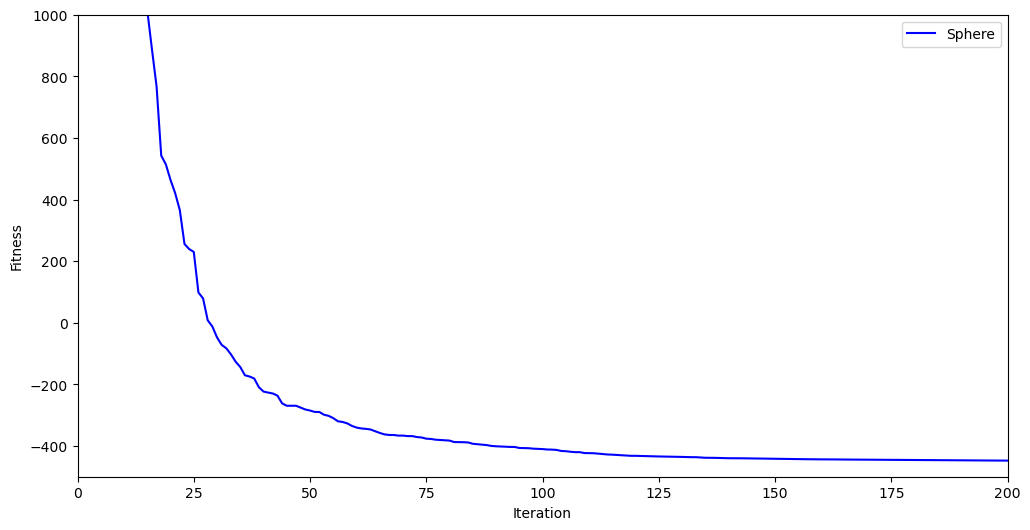

In [11]:
make_line_graph(out_list, "Sphere", [0, 200], [-500,1000])

# Expanded extended Griewank’s plus Rosenbrock’s function (F8F2)

In [12]:
w_init = 0.9
w_final = 0.4 # inertia
c1 = 2.2 # cognitive (particle)
c2 = 0.9 # surrounding (swarm)
c3 = 0.9 # Global (swarm)
e = 0.8   # Step size

iterations = 1000
dimensions = 15
swarm_size = 400
informants = 6

In [13]:
out_list_f13 = np.zeros(iterations +1)
out_best_list_f13 = []
for i in range(10):
    f13 = PSO(swarm_size,dimensions, w_init, w_final ,c1 ,c2 ,c3 ,e)
    best_out_f13_list = f13.run(shifted_f13, iterations = iterations, \
                    min_value =-3, max_value =1, num_informants = informants)
    out_list_f13 = out_list_f13 + np.asarray(best_out_f13_list)
    out_best_list_f13.append(best_out_f13_list[-1])

Iteration 0 | Best Fitness | -48.996118330162375
Iteration 100 | Best Fitness | -124.62350652757375
Iteration 200 | Best Fitness | -127.20596062229605
Iteration 300 | Best Fitness | -127.83627671571114
Iteration 400 | Best Fitness | -127.97403040698877
Iteration 500 | Best Fitness | -127.99795021440949
Iteration 600 | Best Fitness | -128.00903387749938
Iteration 700 | Best Fitness | -128.01211733722477
Iteration 800 | Best Fitness | -128.01222611751635
Iteration 900 | Best Fitness | -128.0122275726699
Final Best Fitness | -128.01222757496595
Iteration 0 | Best Fitness | 29.849031738245827
Iteration 100 | Best Fitness | -123.78982705978441
Iteration 200 | Best Fitness | -126.7650229822979
Iteration 300 | Best Fitness | -128.20157337501502
Iteration 400 | Best Fitness | -128.43383300248215
Iteration 500 | Best Fitness | -128.64161802240667
Iteration 600 | Best Fitness | -128.71940832768516
Iteration 700 | Best Fitness | -128.75805964154785
Iteration 800 | Best Fitness | -128.760818616952

In [14]:
out_list_f13 = out_list_f13/10.0
out_best_list_f13 = np.asarray(out_best_list_f13)
out_best_std_f13 = np.std(out_best_list_f13)
out_best_mean_f13 = np.mean(out_best_list_f13)
error = (-130 - out_best_list_f13)
print ("BEST FITNESS = {}".format(out_best_list_f13))
print ("Error = {}".format(error))

BEST FITNESS = [-128.01222757 -128.76083059 -128.81099852 -129.3794469  -128.67893706
 -128.01073631 -128.84500609 -128.20176303 -128.5734786  -129.17070835]
Error = [-1.98777243 -1.23916941 -1.18900148 -0.6205531  -1.32106294 -1.98926369
 -1.15499391 -1.79823697 -1.4265214  -0.82929165]


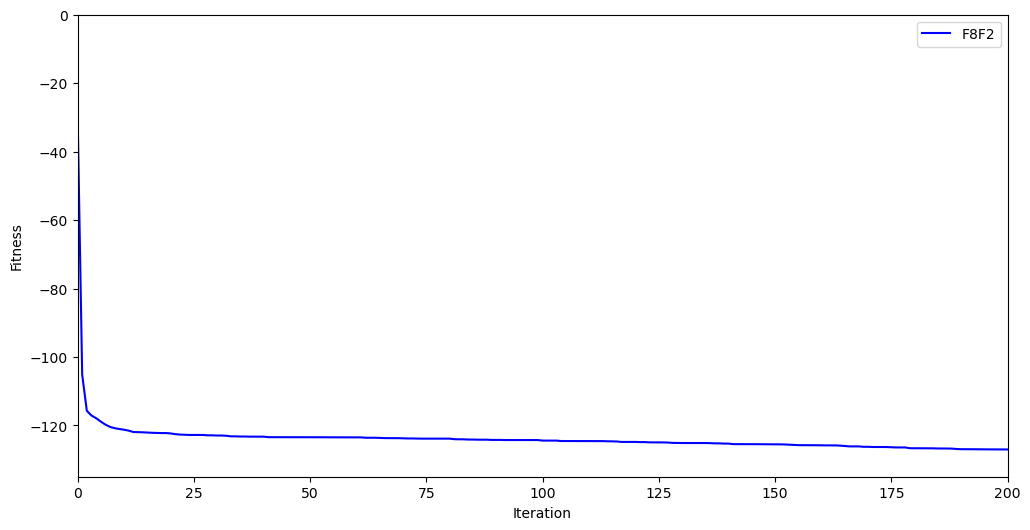

In [15]:
make_line_graph(out_list_f13, "F8F2" , [0,200], [-135, 0])

#  Shifted_Rastrigin

In [16]:
w_init = 0.8
w_final = 0.3 # inertia
c1 = 2 # cognitive (particle)
c2 = 0.9 # surrounding (swarm)
c3 = 0.9 # Global (swarm)
e = 0.7  # Step size
iterations = 500
dimensions = 15
swarm_size = 1000
informants = 8

In [17]:
out_list_rast = np.zeros(iterations +1)
out_best_list_rast = []
for i in range(10):
    print ("RUN {}".format(i+1))
    ps_rast = PSO(swarm_size, dimensions, w_init, w_final ,c1 ,c2 ,c3 ,e)
    best_out_rast_list = ps_rast.run(Shifted_Rastrigin, iterations = iterations,\
                                     min_value =-5,\
                                max_value =5, num_informants = informants)
    out_list_rast = out_list_rast + np.asarray(best_out_rast_list)
    out_best_list_rast.append(best_out_rast_list[-1])

RUN 1
Iteration 0 | Best Fitness | -143.7436182888663
Iteration 100 | Best Fitness | -294.0522201740937
Iteration 200 | Best Fitness | -294.18152852521365
Iteration 300 | Best Fitness | -294.1815294060894
Iteration 400 | Best Fitness | -294.1815294060894
Final Best Fitness | -294.1815294060894
RUN 2
Iteration 0 | Best Fitness | -133.97775354318702
Iteration 100 | Best Fitness | -272.01443418867075
Iteration 200 | Best Fitness | -272.29251572466677
Iteration 300 | Best Fitness | -272.29251592927574
Iteration 400 | Best Fitness | -272.29251592927574
Final Best Fitness | -272.29251592927574
RUN 3
Iteration 0 | Best Fitness | -155.76520822508112
Iteration 100 | Best Fitness | -297.9081772705164
Iteration 200 | Best Fitness | -298.1613601246263
Iteration 300 | Best Fitness | -298.16136059664353
Iteration 400 | Best Fitness | -298.16136059664353
Final Best Fitness | -298.16136059664353
RUN 4
Iteration 0 | Best Fitness | -138.1498027515075
Iteration 100 | Best Fitness | -262.9772176130609
Ite

In [18]:
out_list_rast = out_list_rast/10.0
out_best_list_rast = np.asarray(out_best_list_rast)
out_best_std = np.std(out_best_list_rast)
out_best_mean = np.mean(out_best_list_rast)
error = (-330 - out_best_list_rast)
print ("BEST FITNESS = {}".format(out_best_list_rast))
print ("Error = {}".format(error))

BEST FITNESS = [-294.18152941 -272.29251593 -298.1613606  -284.19709945 -281.24711717
 -289.2067442  -294.1815496  -290.20171841 -292.19163149 -300.15125348]
Error = [-35.81847059 -57.70748407 -31.8386394  -45.80290055 -48.75288283
 -40.7932558  -35.8184504  -39.79828159 -37.80836851 -29.84874652]


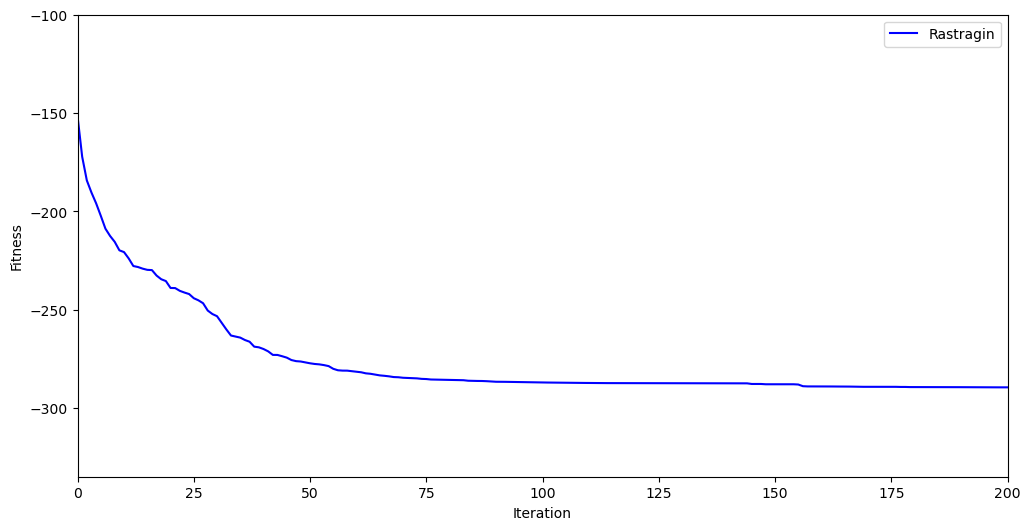

In [19]:
make_line_graph(out_list_rast, "Rastragin", [0,200], [-335, -100])